In [1]:
%matplotlib inline

import os
import json
import math
import sys
import numpy as np
import pandas as pd
import datetime

import matplotlib.pyplot as plt
from matplotlib.dates import date2num

notebook_path = !pwd
prj_path = os.path.abspath(os.path.join(notebook_path[0], '../', ''))
sys.path.append(prj_path)
print('Added: %s' % prj_path)

In /Users/lsanchez/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The text.latex.unicode rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2.
In /Users/lsanchez/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
In /Users/lsanchez/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The pgf.debug rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2.
In /Users/lsanchez/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The verbose.level rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
In /Users/lsanchez/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The verbose.fileo rcparam was deprecated in 

Added: /Users/lsanchez/omath_mota_rulo


In [2]:
from data_scientia import config
from data_scientia.data import capacidad_hospitalaria
from data_scientia.data import municipios
from data_scientia.features import critical_peaks
from data_scientia.features import target_days_to_peak
from data_scientia.features import hospital
from data_scientia.features import train_data
from data_scientia.visualization import hospital_timeline

/Users/lsanchez/anaconda3/envs/py37/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/Users/lsanchez/anaconda3/envs/py37/lib/python3.7/site-packages/statsmodels/compat/pandas.py:23: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  data_klasses = (pandas.Series, pandas.DataFrame, pandas.Panel)


In [3]:
dataset = train_data.get()

In [4]:
municipio_codes_dict = municipios.get_municipio_codes()

/Users/lsanchez/anaconda3/envs/py37/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3325: DtypeWarning: Columns (13) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [5]:
config.VERBOSE = False

data = capacidad_hospitalaria.get()
data.shape

(16780, 15)

In [6]:
peaks_data = critical_peaks.get()
peaks_data.shape

/Users/lsanchez/omath_mota_rulo/data_scientia/features/critical_peaks.py:99: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hospital_data.sort_values('fecha', inplace=True)


(296, 6)

In [7]:
days_to_peak_data = target_days_to_peak.get()
days_to_peak_data.shape

(10593, 22)

In [8]:
n_samples = 5

sample_hospitals = data[
    data['estatus_capacidad_uci'] == 'Crítica'
][
    'nombre_hospital'
].drop_duplicates().sample(
    n_samples, 
    random_state=0)

hospital_name = sample_hospitals.iloc[2]

hospital_name

'HOSPITAL GENERAL DE ZONA 58 (LAS MARGARITAS)'

In [9]:
# Get neighbor municipios daily cases

In [10]:
neighbor_municipios_daily_cases = hospital.get_neighbor_municipio_daily_cases(
    hospital_name, 
    max_meters=15e+3)

neighbor_municipios_daily_cases.columns = [
    municipio_codes_dict[x] for x in 
    neighbor_municipios_daily_cases.columns]

/Users/lsanchez/omath_mota_rulo/data_scientia/features/hospital.py:80: DtypeWarning: Columns (13) have mixed types.Specify dtype option on import or set low_memory=False.
  max_meters=max_meters)[0]


In [11]:
dataset_hospital = dataset[
    dataset['nombre_hospital'] == hospital_name
].set_index('fecha')

# Hospitals timeline

In [12]:
target_name = 'is_next_peak_in_15_days'

/Users/lsanchez/omath_mota_rulo/data_scientia/features/critical_peaks.py:99: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hospital_data.sort_values('fecha', inplace=True)
/Users/lsanchez/omath_mota_rulo/data_scientia/features/critical_peaks.py:99: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hospital_data.sort_values('fecha', inplace=True)


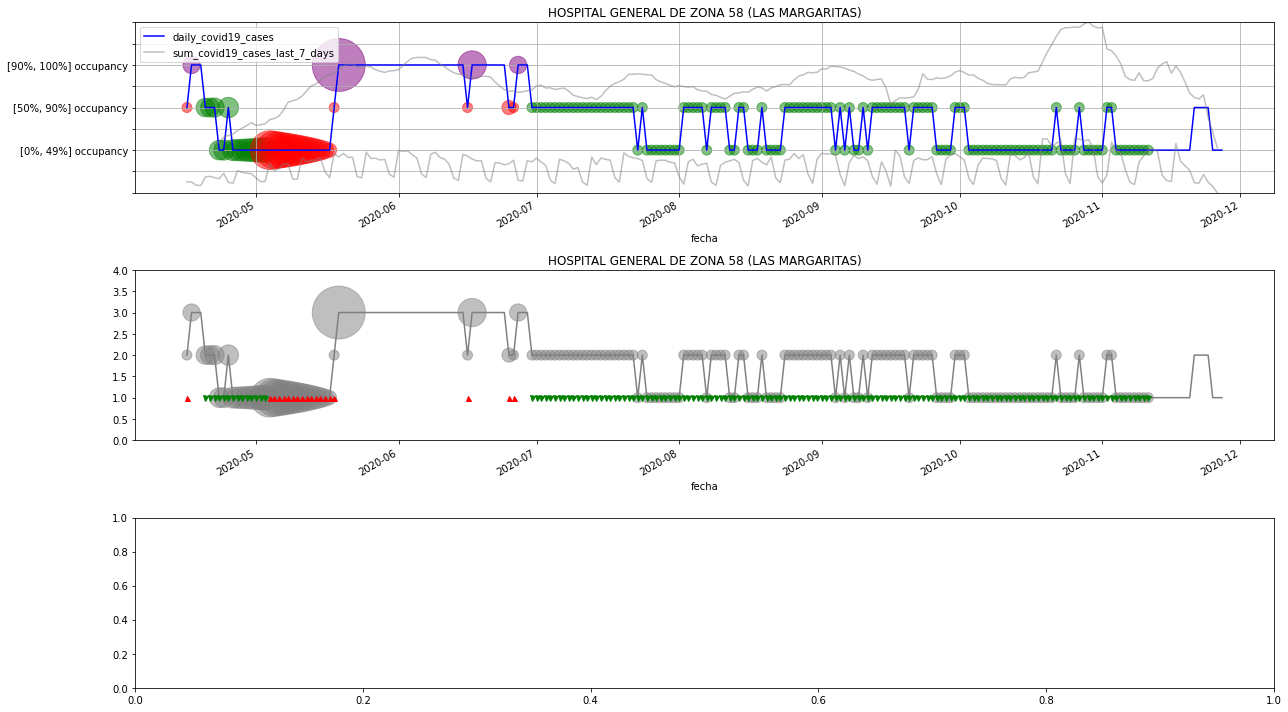

In [58]:
fig, ax = plt.subplots(3, 1, figsize=(18, 10))

hospital_timeline.plot_hospital_timeline(
    hospital_name, 
    ax[0], 
    target_name=target_name)

hospital_timeline.plot_hospital_timeline(
    hospital_name, 
    ax[1],
    gray=True,
    target_name=target_name)

neighbor_municipios_daily_cases = neighbor_municipios_daily_cases.loc[
    data[data['nombre_hospital'] == hospital_name]['fecha'].min():
    data[data['nombre_hospital'] == hospital_name]['fecha'].max()]

covid_cases = neighbor_municipios_daily_cases.sum(axis=1)

data_plot = (covid_cases / 700)
data_plot.name = 'daily_covid19_cases'
data_plot.plot(
    ax=ax[0],
    legend=True,
    alpha=.5,
    grid=True,
    color='gray')


data_plot = (covid_cases.rolling(window=7).sum() / 1200)
data_plot.name = 'sum_covid19_cases_last_7_days'
data_plot.plot(
    ax=ax[0],
    legend=True,
    alpha=.5,
    grid=True,
    color='gray')

dataset_hospital.query('%s == 1' % target_name)[target_name].plot(
    ax=ax[1],
    color='red',
    marker='^',
    markersize=5,
    linestyle='')

(dataset_hospital.query('%s == 0' % target_name)[target_name] + 1).plot(
    ax=ax[1],
    color='green',
    marker='v',
    markersize=5,
    linestyle='')

ax[0].set_yticklabels([
    '',
    '',
    '[0%, 49%] occupancy', 
    '',
    '[50%, 90%] occupancy',
    '',
    '[90%, 100%] occupancy'],
    )

fig.set_tight_layout('tight')

[Text(0, 0.0, 'Bellow 49% occupancy'),
 Text(0, 0.5, 'Between 50%-90% occupancy'),
 Text(0, 1.0, 'Between 90%-100% occupancy')]

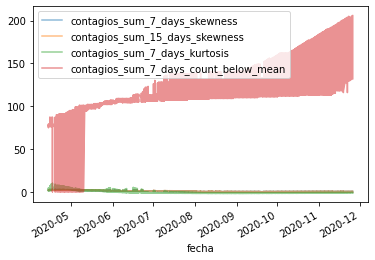

In [39]:
neighbor_municipios_daily_cases = neighbor_municipios_daily_cases.loc[
    data[data['nombre_hospital'] == hospital_name]['fecha'].min():
    data[data['nombre_hospital'] == hospital_name]['fecha'].max()]

features = [
    'contagios_sum_7_days_skewness',
    'contagios_sum_15_days_skewness', 
    'contagios_sum_7_days_kurtosis',
    'contagios_sum_7_days_count_below_mean'
]

dataset.set_index('fecha')[features].plot(
    alpha=.5)
# covid_cases.plot()

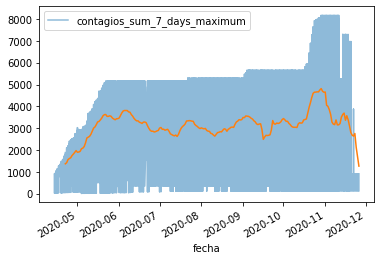

In [38]:
features = [
    'contagios_sum_7_days_maximum']

dataset.set_index('fecha')[features].plot(
    alpha=.5)

covid_cases.rolling(window=7).sum().plot()

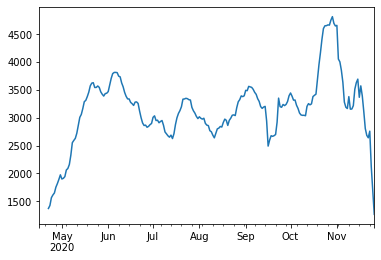

In [36]:
covid_cases.rolling(window=7).sum().plot()